In [418]:
import jax

jax.config.update("jax_compilation_cache_dir", "./jax-cache")
import jax.numpy as jnp

jax.config.update("jax_enable_x64", True)  # use double-precision
jax.config.update("jax_platforms", "cpu")
import numpy as np
import functools

In [419]:
import matplotlib.pyplot as plt
from skimage.morphology import disk, rectangle, ellipse
import itertools
from matplotlib.gridspec import GridSpec

In [420]:
import sys
sys.path.append('../fft_helpers/')

from projection_operators import compute_Ghat_4_2
import tensor_operators as tensor
from fft_operators import laplacian_operator, gradient_operator
from custom_solvers import conjugate_gradient
from pixel_refinement import upscale_binary_array, downscale_binary_array

sys.path.append('../plot_helpers/')
plt.style.use(['../plot_helpers/prl_paper.mplstyle'])

from plot_helper_for_paper import set_size, plot_imshow, plot_contourf

## constructing an architected material 

- inclusion = 1
- solid = 0


We construct the RVE with an volume fraction of 0.7 %

In [421]:
structure = np.load('./figs/blurred_lattice.npy')
structure = np.where(structure < 0.6, 0, 1)
H, L = structure.shape
size = np.minimum(H, L)
if size%2 == 0:
    size = size-1
structure = structure[:size, :size]

In [422]:
length = 1.
H, L = structure.shape
dx = length/H
dy = length/L

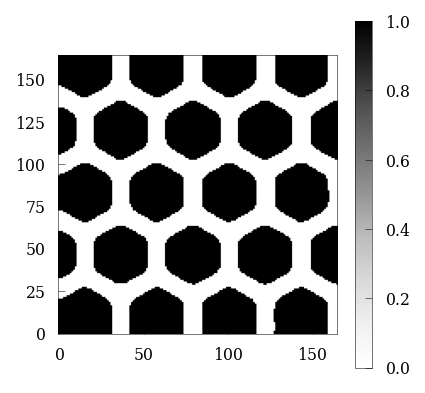

In [424]:
plt.figure(figsize=(3, 3))
cb = plt.imshow(structure, origin="lower", cmap='Greys')
plt.colorbar(cb)
plt.show()

In [425]:
np.sum(1 - structure) / structure.shape[0] / structure.shape[0]

0.4136271808999082

In [426]:
ndim = len(structure.shape)
N = structure.shape[0]
shape = [
    N,
] * ndim

In [427]:
# identity tensor (single tensor)
i = jnp.eye(ndim)

# identity tensors (grid)
I2 = jnp.einsum(
    "ij,xy",
    i,
    jnp.ones(
        [
            N,
        ]
        * ndim
    ),
)
I = jnp.einsum(
    "ij,xy",
    i,
    jnp.ones(
        [
            N,
        ]
        * ndim
    ),
)
I4 = jnp.einsum(
    "ijkl,xy->ijklxy",
    jnp.einsum("il,jk", i, i),
    jnp.ones(
        [
            N,
        ]
        * ndim
    ),
)
I4rt = jnp.einsum(
    "ijkl,xy->ijklxy",
    jnp.einsum("ik,jl", i, i),
    jnp.ones(
        [
            N,
        ]
        * ndim
    ),
)


I4s = (I4 + I4rt) / 2.0
II = tensor.dyad22(I, I)
I4d = I4s - II / 3.0

One must varu the `phase_constrast` variable in the following cells and the resulting `homogneized stiffness tensor` is stored in the variable `output_data`.

In [428]:
output_data = []

## material parameters

In [429]:
# material parameters + function to convert to grid of scalars
@functools.partial(jax.jit, static_argnames=['inclusion', 'solid'])
def param(X, inclusion, solid):
    X = upscale_binary_array(X)
    props = inclusion*jnp.ones_like(X)*(X) + solid*jnp.ones_like(X)*(1-X)
    return downscale_binary_array(props)

In [555]:
# material parameters
phase_contrast = 1/1e4

# lames constant
lambda_modulus = {"solid": 1.0, "inclusion": phase_contrast}
shear_modulus = {"solid": 1.0, "inclusion": phase_contrast}

bulk_modulus = {}
bulk_modulus["solid"] = lambda_modulus["solid"] + 2 * shear_modulus["solid"] / 3
bulk_modulus["inclusion"] = lambda_modulus["inclusion"] + 2 * shear_modulus["inclusion"] / 3

In [556]:
λ0 = param(
    structure, inclusion=lambda_modulus["inclusion"], solid=lambda_modulus["solid"]
)  # lame parameter
μ0 = param(
    structure, inclusion=shear_modulus["inclusion"], solid=shear_modulus["solid"]
)  # lame parameter
K0 = param(structure, inclusion=bulk_modulus["inclusion"], solid=bulk_modulus["solid"])

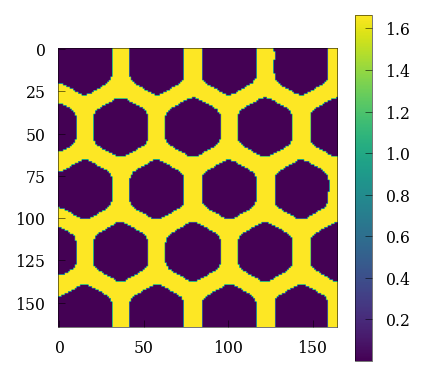

In [557]:
plt.figure(figsize=(3, 3))
plt.imshow(K0)
plt.colorbar()

## linear elastic constitutive relation

Now, we define the stress-strain relationship, for this we directly derive the `stress` function by autodifferentiating the `strain energy` expression.

$$\psi = \dfrac{1}{2}(\text{tr}(\varepsilon_{ii})^2 + \mu \text{tr}(\varepsilon_{ij}\varepsilon_{jk} )$$
$$\sigma_{ij} = \dfrac{\partial \psi}{\partial \varepsilon_{ij}}$$

For FFT scheme, we define the above strain expression for each grid point ($x,y$)

$$\psi_{xy} = \dfrac{1}{2}(\text{tr}(\varepsilon_{iixy})^2 + \mu \text{tr}(\varepsilon_{ijxy}\varepsilon_{jkxy} ) $$
$$\sigma_{ijxy} = \dfrac{\partial \psi_{xy}}{\partial \varepsilon_{ijxy}}$$


In [558]:
@jax.jit
def strain_energy(eps):
    eps_sym = 0.5*(eps + tensor.trans2(eps))
    energy = 0.5 * jnp.multiply(λ0, tensor.trace2(eps_sym)**2) + jnp.multiply(μ0, tensor.trace2(tensor.dot22(eps_sym, eps_sym)))
    return energy.sum()


sigma = jax.jit(jax.jacrev(strain_energy))

## fft helpers and operators

In [559]:
# (inverse) Fourier transform (for each tensor component in each direction)
@jax.jit
def fft(x):
    return jnp.fft.fftshift(jnp.fft.fftn(jnp.fft.ifftshift(x), [N, N]))


@jax.jit
def ifft(x):
    return jnp.fft.fftshift(jnp.fft.ifftn(jnp.fft.ifftshift(x), [N, N]))

Projection tensor

In [560]:
Ghat4_2 = compute_Ghat_4_2(NN=(N,) * ndim, operator="fourier", length=length)

In [561]:
# functions for the projection 'G', and the product 'G : K : eps'
@jax.jit
def G(A2):
    return  jnp.real( ifft( tensor.ddot42(Ghat4_2,fft(A2)) ) ).reshape(-1)

@jax.jit
def G_K_deps(depsm, additionals):
    depsm = depsm.reshape(ndim,ndim,N,N)
    return G(sigma(depsm))

## newton-raphson method

In [562]:
@jax.jit
def solve_elasticity(state, n):
    dF, b, F, Fn = state

    error = jnp.linalg.norm(dF)/Fn
    jax.debug.print('residual={}', error)

    def true_fun(state):
        dF, b, F, Fn = state

        dF, iiter = conjugate_gradient(
                atol=1e-8, 
                A = G_K_deps,
                b = b,
                additional=None
        )                                   # solve linear system using CG

        dF     = dF.reshape(ndim,ndim,N,N)
        F      = jax.lax.add(F, dF)         # update DOFs (array -> tensor.grid)
        P      = sigma(F)            # new residual stress
        b      = -G_K_deps(F, None)        # compute residual

        return (dF,  b, F, Fn)

    def false_fun(state):
        return state

    return jax.lax.cond(error > 1e-5, true_fun, false_fun, state), n

## testing elastic subproblem for a loaded state

In [563]:
sig      = jnp.zeros([ndim,ndim,N,N])
eps      = jnp.zeros([ndim,ndim,N,N])


deps      = jnp.zeros([ndim,ndim,N,N])
deps      = deps.at[0, 0].set(1e-1)
deps      = deps.at[1, 1].set(1e-1)

# initial residual: distribute "DE" over grid using "K4"
b        = -G_K_deps(deps, None)
eps      = jax.lax.add(eps, deps) 
En       = jnp.linalg.norm(eps)

In [564]:
state = (deps, b, eps, En)
state = jax.device_put(state)

In [565]:
final_state, xs = jax.lax.scan(solve_elasticity, 
                               init=state, 
                               xs=jnp.arange(0, 20))

residual=1.0
residual=4.791224378963107
residual=2.1222069518305133
residual=0.51047024773875
residual=0.2459681908166417
residual=0.09547964907365405
residual=0.053494419818222665
residual=0.022037303650182295
residual=0.012729669868678545
residual=0.005375389731348785
residual=0.003148844637535354
residual=0.0013484402399592931
residual=0.0007963198325571266
residual=0.00034413763362974183
residual=0.00020429955008825502
residual=8.885784151897348e-05
residual=5.2944424576798164e-05
residual=2.3136342328696376e-05
residual=1.3822382322012359e-05
residual=6.061963077398588e-06


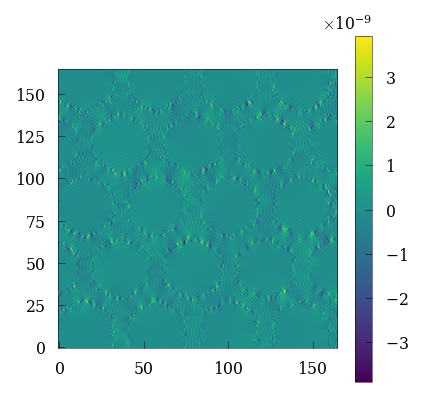

In [566]:
plt.figure(figsize=(3,3))
plt.imshow(final_state[1].reshape([ndim, ndim, N, N]).at[1, 1].get(), origin='lower')
plt.colorbar()

In [567]:
sig = sigma(final_state[2])

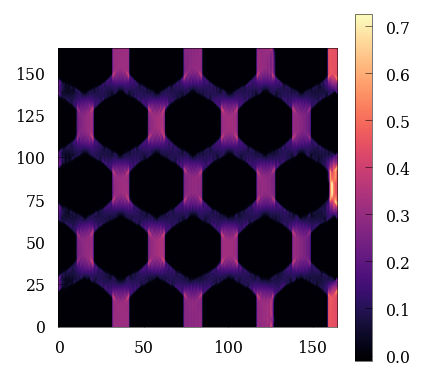

In [568]:
plt.figure(figsize=(3,3))
plt.imshow(sig.at[0, 0].get(), origin='lower',cmap='magma')
plt.colorbar()

In [569]:
@jax.jit
def local_constitutive_update(macro_strain):

    # ----------------------------- NEWTON ITERATIONS -----------------------------
    # initialize stress and strain tensor                         [grid of tensors]
    eps      = jnp.zeros([ndim,ndim,N,N])
    # set macroscopic loading
    DE = jnp.zeros([ndim,ndim,N,N])
    DE = DE.at[0, 0].set(macro_strain[0])
    DE = DE.at[1, 1].set(macro_strain[1])
    DE = DE.at[0, 1].set(macro_strain[2]/2.)
    DE = DE.at[1, 0].set(macro_strain[2]/2.)

    # initial residual: distribute "DE" over grid using "K4"
    b        = -G_K_deps(DE, None)
    eps      = jax.lax.add(eps, DE) 
    En       = jnp.linalg.norm(eps)

    state = (DE, b, eps, En)
    initial_state = jax.device_put(state)

    final_state, xs = jax.lax.scan(solve_elasticity, 
                               init=initial_state, 
                               xs=jnp.arange(0, 20))
    
    DE, b, eps, En = final_state
    sig = sigma(eps)

    # get the macro stress
    macro_sigma = jnp.array([jnp.sum(sig.at[0, 0].get()*dx*dy), 
                             jnp.sum(sig.at[1, 1].get()*dx*dy), 
                             0.5*(jnp.sum(sig.at[1, 0].get()*dx*dy) + jnp.sum(sig.at[0, 1].get()*dx*dy))])
    macro_sigma = macro_sigma/length**2
    
    return macro_sigma, (macro_sigma, sig, eps)

In [570]:
tangent_operator_and_state = jax.jit(jax.jacfwd(
    local_constitutive_update, argnums=0, has_aux=True
))

In [571]:
deps = jnp.array([-1e-3, -1e-3, 0])

In [572]:
tangent, state = tangent_operator_and_state(deps)

residual=1.0
residual=4.791224378961814
residual=2.122207039848551
residual=0.5104700646418225
residual=0.24596834516991073
residual=0.09547963046984115
residual=0.05349443008446421
residual=0.0220372939750884
residual=0.012729665608874674
residual=0.005375383076176467
residual=0.0031488412010707676
residual=0.0013484373993410215
residual=0.0007963183117778397
residual=0.0003441365843447523
residual=0.00020429898586994875
residual=8.885747305586993e-05
residual=5.2944215190179884e-05
residual=1.5304533430061643e-06
residual=1.5304533430061643e-06
residual=1.5304533430061643e-06


In [573]:
print(f"homogenized stiffness tensor for phase contrast ={phase_contrast}") 

homogenized stiffness tensor for phase contrast =0.0001


In [574]:
tangent

Array([[ 0.49130836,  0.23343134, -0.001179  ],
       [ 0.23343132,  0.39887268, -0.00057029],
       [-0.00117894, -0.00057032,  0.05264224]], dtype=float64)

In [575]:
output_data.append([phase_contrast, tangent[0,0], tangent[1,1], tangent[2, 2], tangent[0, 1]])

In [576]:
from scipy.ndimage import gaussian_filter
import matplotlib.patches as mpatches
import matplotlib as mpl

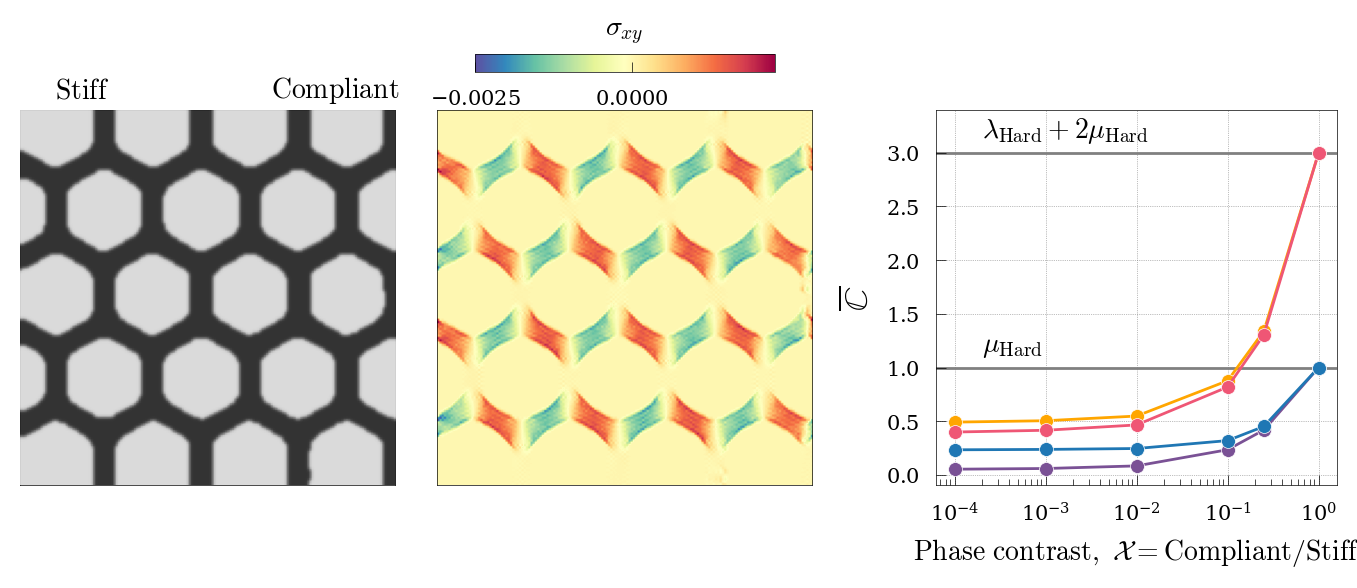

In [581]:
fig = plt.figure(figsize=set_size(width='two-column', fraction=0.95, height_ratio=0.42), 
                 constrained_layout=True, dpi=200)
gs1 = GridSpec(1, 3, figure=fig, width_ratios=[1, 1, 1])

ax = fig.add_subplot(gs1[0, 0])


blurred = gaussian_filter(np.asarray(structure, dtype=float), sigma=0.8)
ax.imshow(blurred, alpha=0.7,  cmap='Greys', zorder=30, origin='lower')
ax.imshow(gaussian_filter(np.asarray(1-structure, dtype=float), sigma=0.8), alpha=0.8,  cmap='Greys', zorder=30, origin='lower')

ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.text(15, 170, r"$\mathrm{Stiff}$", fontsize=10)
ax.text(110, 170, r"$\mathrm{Compliant}$", fontsize=10)

ax = fig.add_subplot(gs1[0, 1])
plot_imshow(fig=fig, ax=ax,
            quantity=state[1].at[0, 1].get(),
            title=r'$\sigma_{xy}$', cmap='Spectral_r')
plt.savefig('./figs/paper_lattice_material2.pdf')

ax = fig.add_subplot(gs1[0, 2])
output_data_arr = np.asarray(output_data)
output_data_arr = output_data_arr[output_data_arr[:, 0].argsort()]

ax.plot(output_data_arr[:, 0], output_data_arr[:, 1], marker='o', 
       markersize=5, color='#ffa600', markeredgecolor='w')
ax.plot(output_data_arr[:, 0], output_data_arr[:, 2], marker='o',
               markersize=5, color='#ef5675', markeredgecolor='w')
ax.plot(output_data_arr[:, 0], output_data_arr[:, 3], marker='o',
               markersize=5, color='#7a5195', markeredgecolor='w')
ax.plot(output_data_arr[:, 0], output_data_arr[:, 4], marker='o', markersize=5, markeredgecolor='w')
ax.axhline(y=lambda_modulus['solid'] + 2*shear_modulus['solid'], color='Grey', zorder=-1)
ax.axhline(y=shear_modulus['solid'], color='Grey', zorder=-1)
ax.set_xscale('log')
ax.grid()
ax.set_xlabel(r'$\mathrm{Phase~contrast,~}\mathcal{X} = \mathrm{Compliant/Stiff}$', fontsize=10)
ax.set_ylabel(r'$\overline{\mathbb{C}}$', fontsize=12)
ax.text(0.0002, 3.15, r"$\lambda_\mathrm{Hard} + 2\mu_\mathrm{Hard}$", fontsize=10)
ax.text(0.0002, 1.15, r"$\mu_\mathrm{Hard}$", fontsize=10)

ax.set_ylim(top=3.4)

#plot_imshow(fig=fig, ax=ax,
#            quantity=state[1].at[0, 0].get(),
#            title=r'$\sigma_{yy}$', cmap='inferno_r')
plt.savefig('./figs/paper_lattice_material2.svg')
plt.show()